In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.tri as tri
from reorder import reorder_coords

In [51]:
def convert_list_to_array(input_list):
    # Initialize an empty list to store all the numbers
    all_numbers = []
    
    # Iterate through each string in the input list
    for string in input_list:
        # Split the string by whitespace and convert each number to float
        numbers = [float(num) for num in string.strip().split()]
        # Extend the all_numbers list with these numbers
        all_numbers.extend(numbers)
    
    # Convert the list of all numbers to a numpy array
    return np.array(all_numbers)

In [52]:
def mask_dims(vars, xmin, max, ymin, ymax):
    # Apply z mask
    mask = vars[2]<0.5
    vars = [var[mask] for var in vars]

    # Apply x mask
    mask = vars[0]>xmin
    vars = [var[mask] for var in vars]
    mask = vars[0]<xmax
    vars = [var[mask] for var in vars]

    # Apply y mask
    mask = vars[1]>ymin
    vars = [var[mask] for var in vars]
    mask = vars[1]<ymax
    vars = [var[mask] for var in vars]

    return vars

In [53]:
xmin, xmax = -0.75, 1.75
ymin, ymax = -0.75, 0.75

In [54]:
file_path = 'data/case_1005_surf_0.dat'  # Replace with your file path
with open(file_path, 'r') as f:
    s = f.readlines()

ncols = 5
nvars = 8

In [63]:
# Extract wall zone
nnods = []
nelms = []

wall_vars = []

for i, line in enumerate(s):
    if line.strip().startswith('ZONE T="wall"'):
        nnod = int(s[i+2].split('=')[1].split()[0].split(',')[0])
        nelm = int(s[i+2].split('=')[2].split()[0].split(',')[0])

        if nnod % ncols == 0:
            nrows = nnod//ncols
        else:
            nrows = nnod//ncols + 1

        for j in range(nvars):
            offset = nrows*j
            dat = convert_list_to_array(s[offset+i+5:offset+i+nrows+5])
            wall_vars.append(dat)

        break


wall_vars = mask_dims(wall_vars, xmin, max, ymin, ymax)

In [64]:
# Extract symm zone
nnods = []
nelms = []

sym_vars = []

for i, line in enumerate(s):
    if line.strip().startswith('ZONE T="sym"'):
        nnod = int(s[i+2].split('=')[1].split()[0].split(',')[0])
        nelm = int(s[i+2].split('=')[2].split()[0].split(',')[0])

        if nnod % ncols == 0:
            nrows = nnod//ncols
        else:
            nrows = nnod//ncols + 1

        for j in range(nvars):
            offset = nrows*j
            dat = convert_list_to_array(s[offset+i+5:offset+i+nrows+5])
            sym_vars.append(dat)

        break

sym_vars = mask_dims(sym_vars, xmin, xmax, ymin, ymax)

In [65]:
# Extract far zone
nnods = []
nelms = []

far_vars = []

for i, line in enumerate(s):
    if line.strip().startswith('ZONE T="far"'):
        nnod = int(s[i+2].split('=')[1].split()[0].split(',')[0])
        nelm = int(s[i+2].split('=')[2].split()[0].split(',')[0])

        if nnod % ncols == 0:
            nrows = nnod//ncols
        else:
            nrows = nnod//ncols + 1

        for j in range(nvars):
            offset = nrows*j
            dat = convert_list_to_array(s[offset+i+5:offset+i+nrows+5])
            far_vars.append(dat)

        break

far_vars = mask_dims(far_vars, xmin, xmax, ymin, ymax)

In [68]:
# Keep only X-coordinate, Y-Coordinate, CoefPressure, VelocityX, and VelocityY data
idxs = [0, 1, 3, 4, 6]
wall_vars = [wall_vars[i] for i in idxs]
sym_vars  = [sym_vars[i] for i in idxs]
far_vars  = [far_vars[i] for i in idxs]

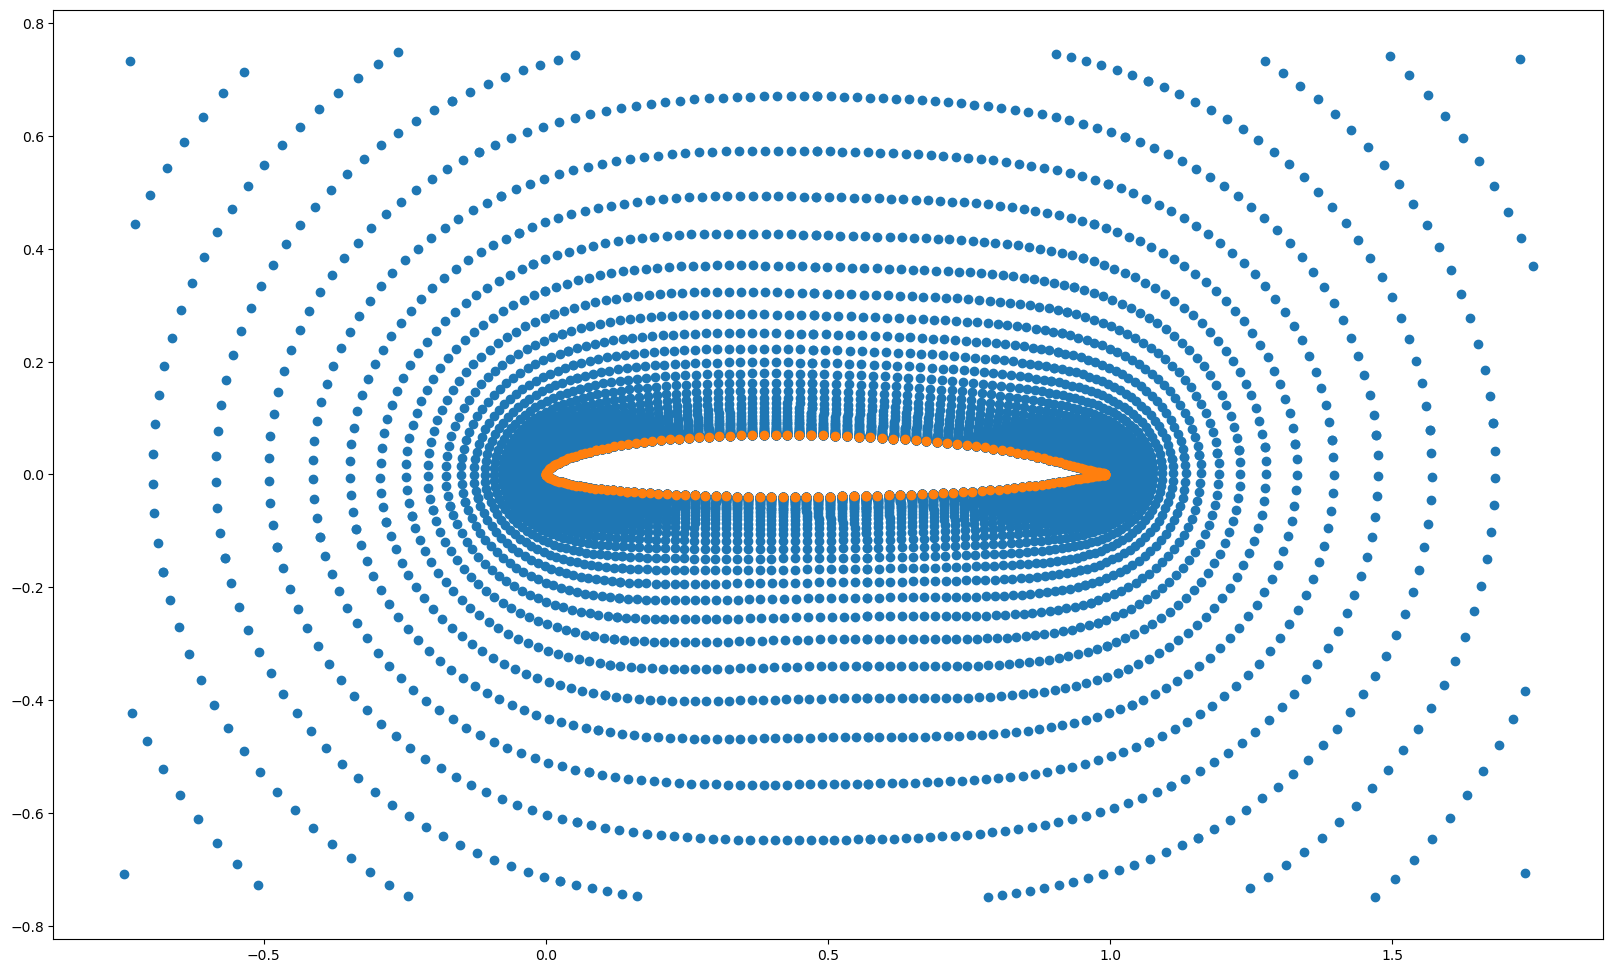

In [69]:
fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(sym_vars[0], sym_vars[1])
ax.scatter(wall_vars[0], wall_vars[1])

ax.set_aspect('equal')
#ax.set_xlim([-.5,1.5])
#ax.set_ylim([-.5,.5])

plt.show()

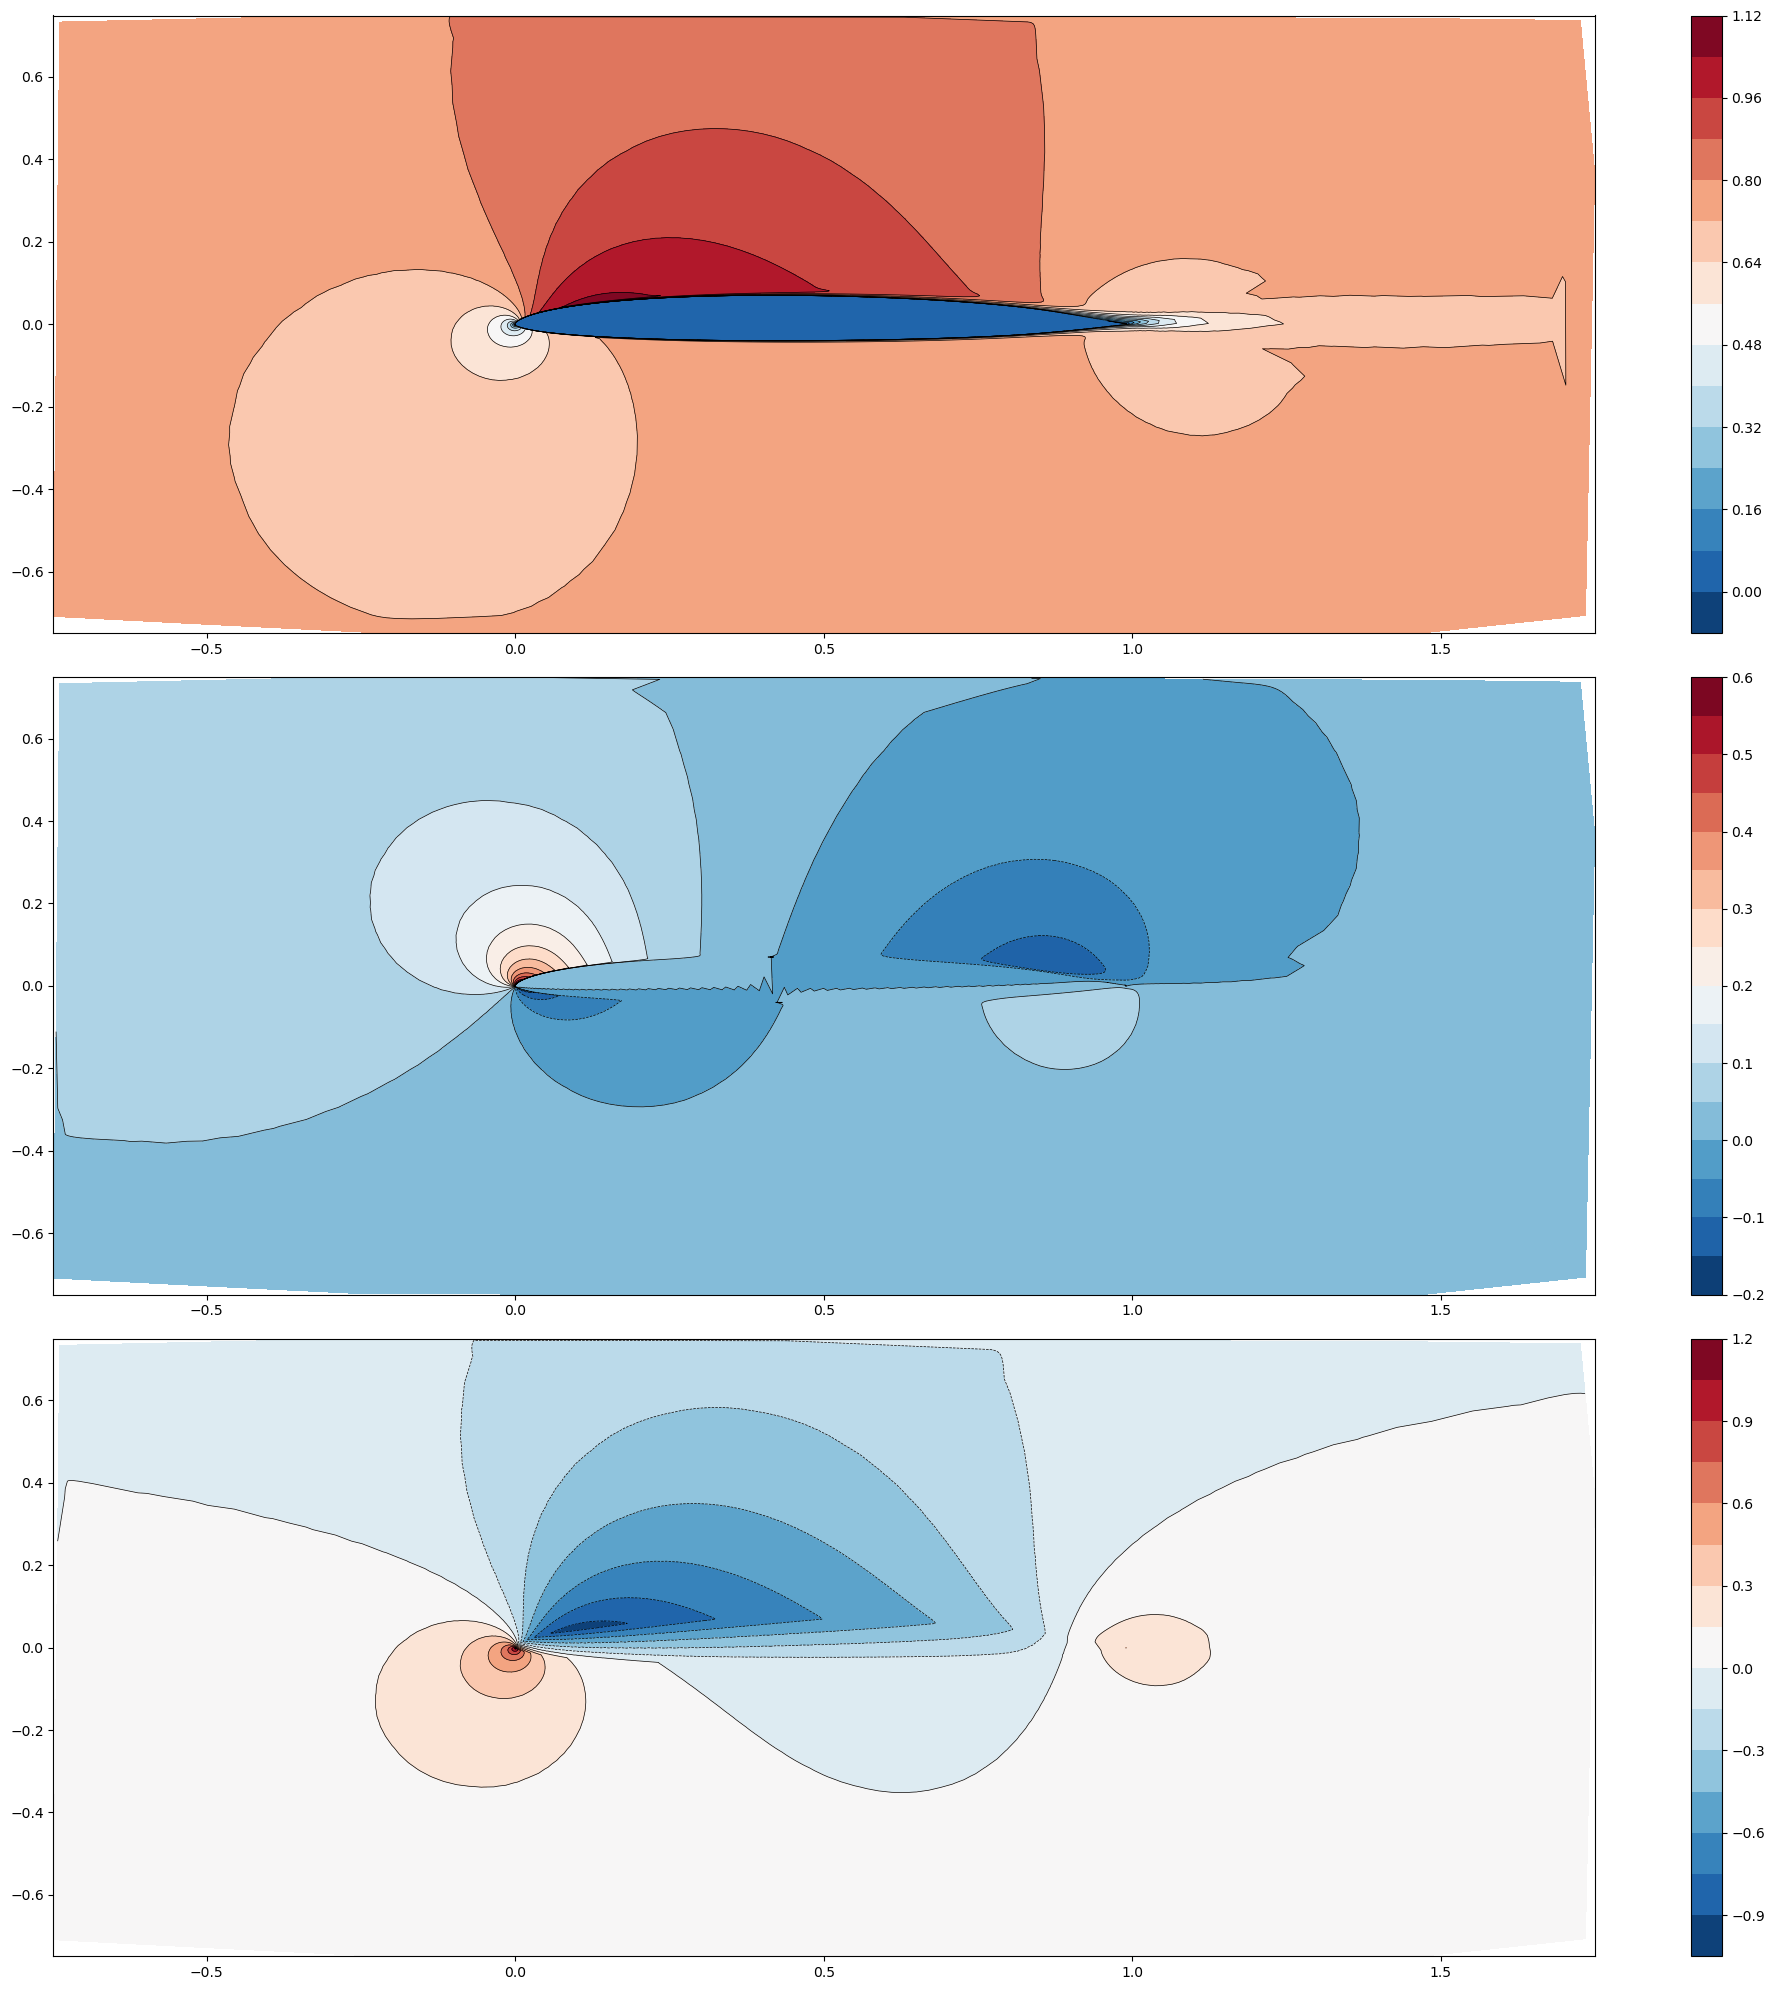

In [77]:
fig, axs = plt.subplots(nrows= 3, ncols = 1, figsize=(20,20), tight_layout=True)
x, y = sym_vars[0], sym_vars[1]

for i, ax in enumerate(axs.reshape(-1)):
    z = sym_vars[2+i]
    ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    fig.colorbar(cntr2)

In [11]:
ngrid = 256
ngridx = ngrid
ngridy = ngrid
xi = np.linspace(xmin, xmax, ngridx)
yi = np.linspace(ymin, ymax, ngridy)

z = sym_vars[3]

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

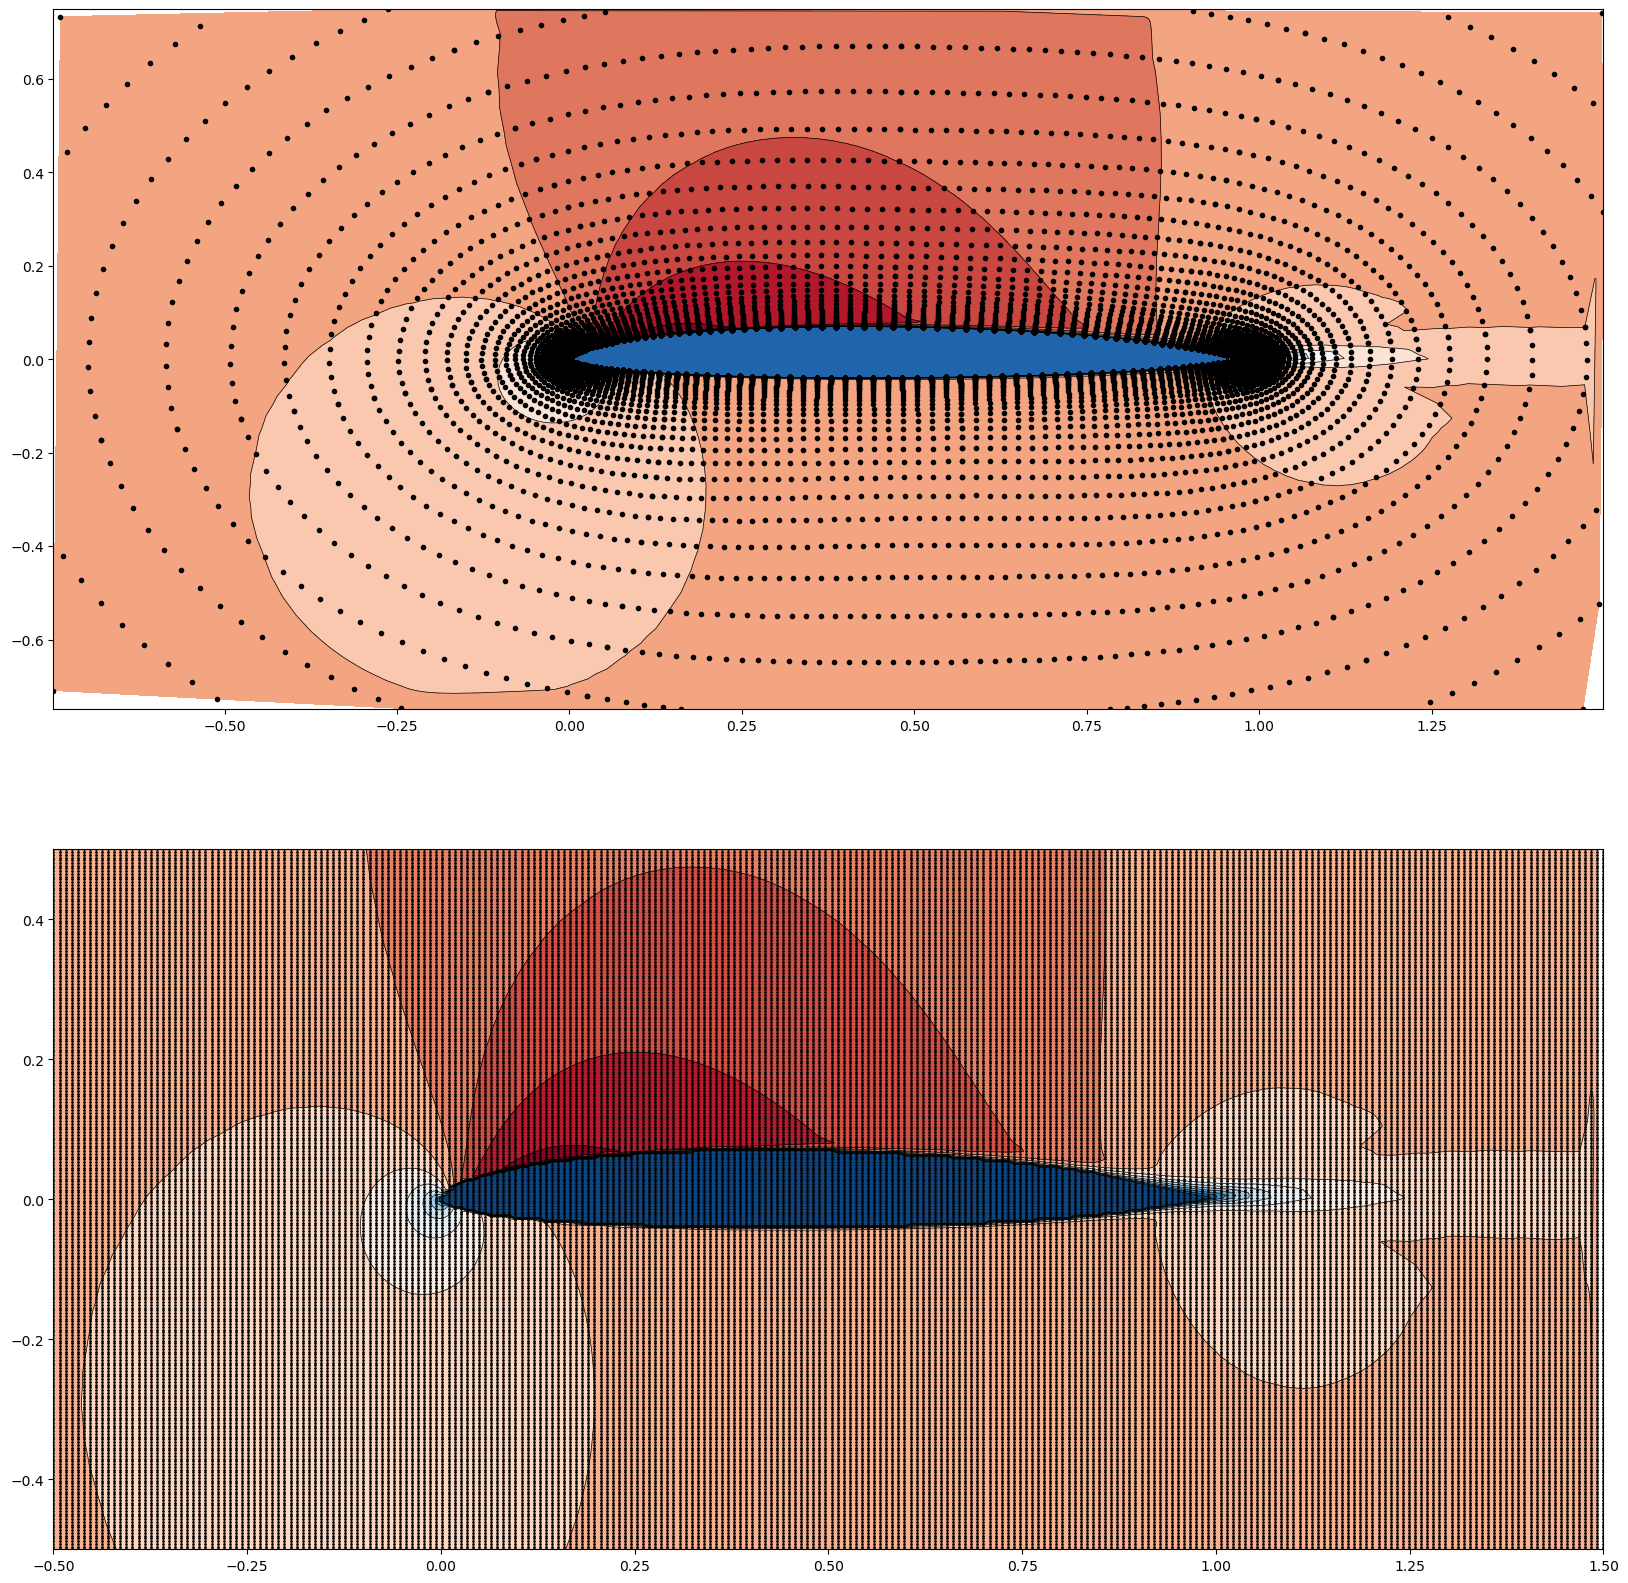

In [12]:
fig, axs = plt.subplots(nrows= 2, ncols = 1, figsize=(20,20))

axs[0].tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr1 = axs[0].tricontourf(x, y, z, levels=14, cmap="RdBu_r")
axs[0].plot(x, y, 'ko', ms=3)

axs[1].contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr2 = axs[1].contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
axs[1].plot(Xi.ravel(), Yi.ravel(), 'ko', ms=1)

In [13]:
# Extract geometry data from slice file
file_path = 'data/case_1005_slice_0.dat'  # Replace with your file path
with open(file_path, 'r') as f:
    s = f.readlines()

In [14]:
# Extract wall zone
ncols = 5
nvars = 11

nnods = []
nelms = []

wall_vars = []

for i, line in enumerate(s):
    if line.strip().startswith('DATAPACKING=BLOCK'):
        nnod = int(s[i-1].split('=')[1].split()[0].split(',')[0])
        nelm = int(s[i-1].split('=')[2].split()[0].split(',')[0])
        
        if nnod % ncols == 0:
            nrows = nnod//ncols
        else:
            nrows = nnod//ncols + 1

        for j in range(nvars):
            offset = nrows*j + 2
            #print(s[offset+i:offset+i+nrows])
            dat = convert_list_to_array(s[offset+i:offset+i+nrows])
            wall_vars.append(dat)

        connectivity = np.genfromtxt(s[offset+i+nrows:offset+i+nrows+nnod], dtype=float)
        df_conn = pd.DataFrame(connectivity, columns=['NodeC1', 'NodeC2'])

        break

wall_vars = np.array(wall_vars).T
d2_df = pd.DataFrame(wall_vars[:,[0,1,2,6,7,8,9]], columns=['CoordinateX', 'CoordinateY', 'CoordinateZ', 'VX', 'VY', 'VZ', 'CP'])

result = pd.concat([d2_df, df_conn], axis=1)
d2_df = result.reindex(d2_df.index)

index_list = list(reorder_coords(d2_df, return_indices=True))
d2_df = d2_df.loc[index_list]

In [17]:
d2_df

,CoordinateX,CoordinateY,CoordinateZ,VX,VY,VZ,CP,NodeC1,NodeC2
96,1.185020e-04,-0.000783,0.5,-0.003496,0.012513,2.530959e-17,1.028041,101.0,102.0
97,6.098110e-04,-0.001742,0.5,-0.002121,0.004125,6.743249e-18,1.124012,102.0,103.0
98,1.639810e-03,-0.002865,0.5,0.001907,-0.001555,-3.313178e-18,1.069440,103.0,104.0
99,3.144590e-03,-0.004113,0.5,0.005866,-0.004304,-7.375628e-18,0.971515,104.0,105.0
100,5.133640e-03,-0.005460,0.5,0.008838,-0.005461,-5.509765e-18,0.877258,105.0,106.0
...,...,...,...,...,...,...,...,...,...
186,3.874690e-04,0.001964,0.5,0.008569,0.024529,-6.688172e-18,0.603727,NaN,NaN
187,9.434790e-05,0.000928,0.5,0.004916,0.022763,7.082440e-18,0.742773,NaN,NaN
188,5.706900e-06,0.000291,0.5,0.001839,0.020383,1.955535e-17,0.796427,NaN,NaN
189,-9.233160e-07,0.000077,0.5,-0.000190,0.020129,3.611862e-17,0.777769,NaN,NaN
